In [29]:
from drn_interactions.transforms import SpikesHandlerMulti
from drn_interactions.transforms.shock_transforms import ShockUtils
from drn_interactions.plots.heatmaps import state_indicator, similarity_map
from drn_interactions.config import ExperimentInfo, Config
from drn_interactions.umap import umap_spikes
from drn_interactions.plots.umap import plot_umap

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import minmax_scale, robust_scale, LabelEncoder
from scipy.ndimage import gaussian_filter1d, median_filter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Sequence


In [39]:
class Loader:
    def __init__(
        self,
        session_name,
        bin_width=1,
        gaussian_sigma=None,
        t_start=-600,
        t_stop=1200,
    ):
        self.session_name = session_name
        self.bin_width = bin_width
        self.gaussian_sigma = gaussian_sigma
        self.t_start = t_start
        self.t_stop = t_stop

    def preprocess_spikes(self, spikes: pd.DataFrame) -> pd.DataFrame:
        if self.gaussian_sigma is not None:
            spikes = spikes.transform(gaussian_filter1d, sigma=self.gaussian_sigma)
        vals = TfidfTransformer().fit_transform(spikes).todense()
        spikes = (
            pd.DataFrame(vals, columns=spikes.columns, index=spikes.index)
            .apply(minmax_scale)
            .T
        )
        return spikes

    def get_spikes(
        self,
        preprocess: bool=True,
    ):
        sessions = ExperimentInfo.foot_shock_sessions_10min
        sh = SpikesHandlerMulti(
            block=["base_shock", "post_base_shock"],
            bin_width=1,
            session_names=[self.session_name],
            t_start=self.t_start,
            t_stop=self.t_stop,
        )
        spikes = sh.binned_piv
        if preprocess:
            spikes = self.preprocess_spikes(spikes).T
        return spikes

    def get_states(
        self,
        spikes: pd.DataFrame,
        t_start: float = -600,
        t_end: float = 1200,
        name: str = "State",
    ):
        time = spikes.index
        states = np.where(time < 0, "Pre", np.where(time < 600, "Shock", "Post"))
        return pd.Series(states, index=time, name=name)


class Plotter:
    def __init__(self, spikes_cmap="Greys", spikes_vmin=0, spikes_vmax=1):
        self.spikes_cmap = spikes_cmap
        self.spikes_vmin = spikes_vmin
        self.spikes_vmax = spikes_vmax

    def plot_spikes(self, spikes: pd.DataFrame, ax: plt.Axes, **kwargs):
        sns.heatmap(
            spikes,
            cmap=self.spikes_cmap,
            vmin=self.spikes_vmin,
            vmax=self.spikes_vmax,
            ax=ax,
            **kwargs
        )
        return ax
    
    def plot_simmilarity(self, spikes: pd.DataFrame, ax: plt.Axes, **kwargs):
        similarity_map(spikes, ax=ax, **kwargs)
        return ax

    def plot_states(
        self,
        states: pd.Series,
        ax: plt.Axes,
        order: Sequence[str] = ("Pre", "Shock", "Post"),
        **kwargs
    ):
        state_indicator(states=states, order=order, ax=ax, **kwargs)
        return ax
    
    def plot_umap(self, spikes: pd.DataFrame, ax: plt.Axes, **kwargs):
        plot_umap(spikes, ax=ax, **kwargs)
        return ax


In [40]:
sessions = ExperimentInfo.foot_shock_sessions_10min

plotter = Plotter()
loader = Loader(session_name=sessions[2], t_start=-600, t_stop=1200, gaussian_sigma=1)
spikes = loader.get_spikes().T
spikes_sim = loader.get_spikes(preprocess=False)
states = loader.get_states(spikes=spikes_sim)

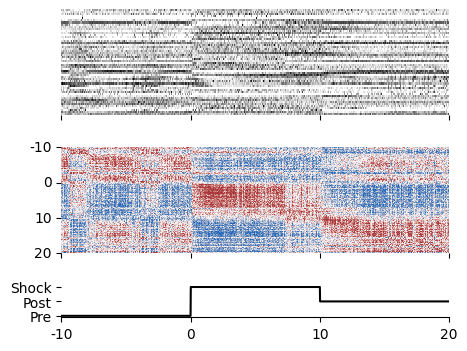

In [74]:
f = plt.figure(figsize=(5, 4))

ax_spikes, ax_sim, ax_states = f.subplots(3, 1, gridspec_kw=dict(height_ratios=[1, 1, 0.3]))

plotter.plot_spikes(
    spikes, 
    ax_spikes, 
    xticklabels=[], 
    yticklabels=[], 
    cbar=False
    )
ax_spikes.set_xlabel("")
ax_spikes.set_ylabel("")
ax_spikes.xaxis.set_major_locator(plt.FixedLocator([0, 600, 1200, 1799]))

##

plotter.plot_simmilarity(
    spikes_sim,
    ax_sim, 
    z=True,
    heatmap_kwargs=dict(cmap="vlag", cbar=False, robust=True, ),
    locater_y=plt.FixedLocator([0, 600, 1200, 1799]),
    locater_x=plt.FixedLocator([0, 600, 1200, 1799]),
    formater_y=plt.FixedFormatter([-10, 0, 10, 20]),
    formater_x=plt.NullFormatter(),
    )
ax_sim.set_xlabel("")
ax_sim.set_ylabel("")

plotter.plot_states(
    states, 
    ax_states, 
    order=("Pre", "Post", "Shock"),
    locater_x=plt.FixedLocator([-600, 0, 600, 1198]), 
    formater_x=plt.FixedFormatter([-10, 0, 10, 20])
    )

f.subplots_adjust(hspace=0.4)
f.savefig(Config.fig_dir / "fs - decode example heats.png", dpi=300, bbox_inches="tight")

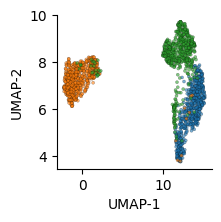

In [75]:
f = plt.figure(figsize=(2, 2))
ax = f.subplots()

df_umap = umap_spikes(
    spikes_sim,
).set_index("bin")
plot_umap(
    df_umap.join(states),
    y="State",
    ax=ax,
    remove_legend=True,
    alpha=0.6,
    scatter_kwargs=dict(s=5.0),
)

f.savefig(
    Config.fig_dir / "fs - decode example umap (r-shock b-pre).png",
    dpi=300,
    bbox_inches="tight",
)
